In [7]:
import pandas as pd
from tqdm import tqdm

path = "/gscratch/cse/lee0618/cifar-100/meta/pairs.csv"
df = pd.read_csv(path)

md_path = "/gscratch/cse/lee0618/cifar-100/meta/train.csv"
md = pd.read_csv(md_path)

print(len(df))
superclass_agreement = df.loc[df["aux_1"] == df["aux_2"]]
label_agreement = df.loc[df["label_1"] == df["label_2"]]
# for i in tqdm(range(len(df))):
#     assert md.loc[md["id"] == df.loc[i, "id_1"]].iloc[0]["group"] == 1
#     assert md.loc[md["id"] == df.loc[i, "id_2"]].iloc[0]["group"] == 2
print(len(superclass_agreement) / len(df))
print(len(label_agreement) / len(df))

36296
0.6824994489750936
0.5403625743883623


In [ ]:
import os
import sys
import torch

sys.path.insert(0, "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/models")
sys.path.insert(0, "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src")
from models.resnet_autoencoder import ResNet, get_configs

configs, bottleneck = get_configs()
model = ResNet(configs=configs, bottleneck=bottleneck, num_classes=100, pretrained=False)

x = torch.rand((2, 3, 224, 224))
model(x)

# CIFAR100 Unbalanced Groups Distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def get_unbalanced_distribution(plot=False):
    np.random.seed(1)
    num_classes = 20
    # dist_first_half = np.random.uniform(low=0.1, high=0.5, size=num_classes//2)
    # dist_second_half = np.random.uniform(low=0.5, high=1.0, size=num_classes//2)
    dist_first_half = np.ones(num_classes//2) * 0.2
    dist_second_half = np.ones(num_classes//2) * 0.8
    dist = np.concatenate([dist_first_half, dist_second_half])
    if plot:
        fig = plt.figure(figsize=(30, 10))
        plt.bar(x=range(len(dist)), height=dist, color=["green" for i in range(10)] + ["blue" for i in range(10)])
    return dist / sum(dist)

# CIFAR100 pairs sample distribution

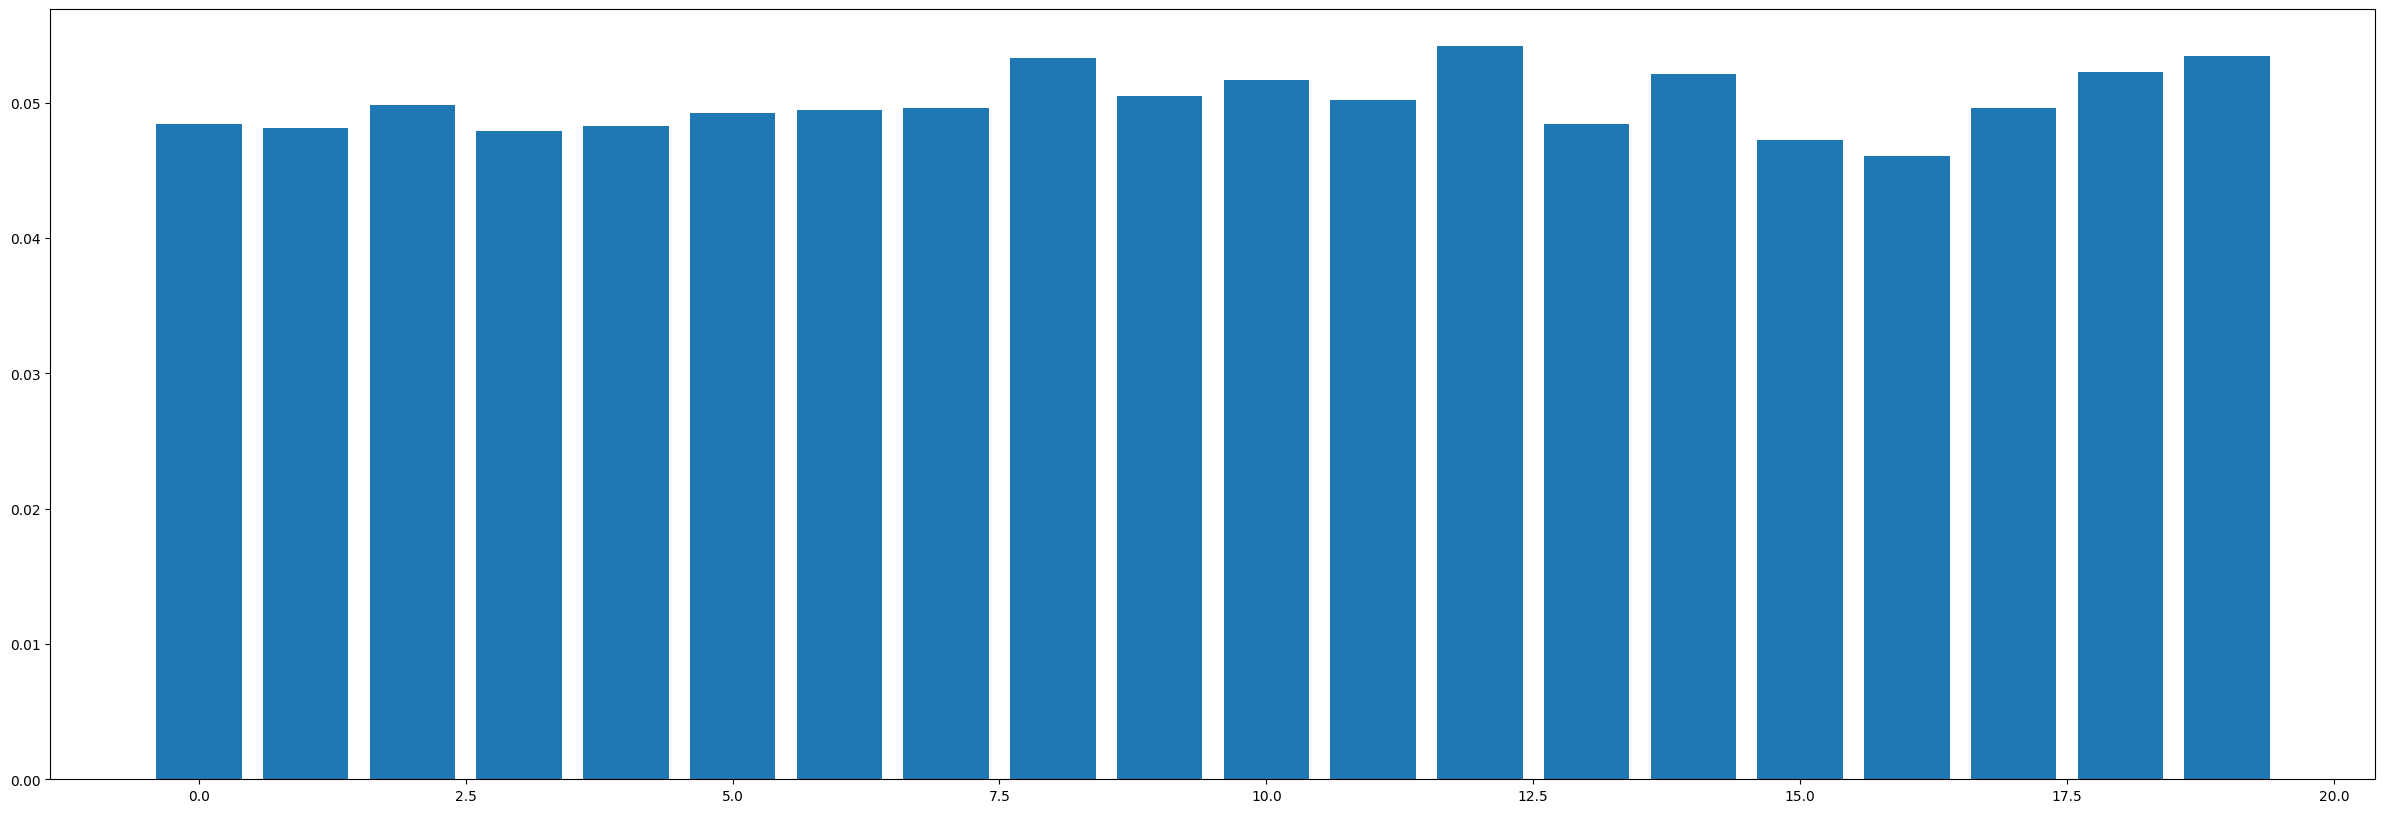

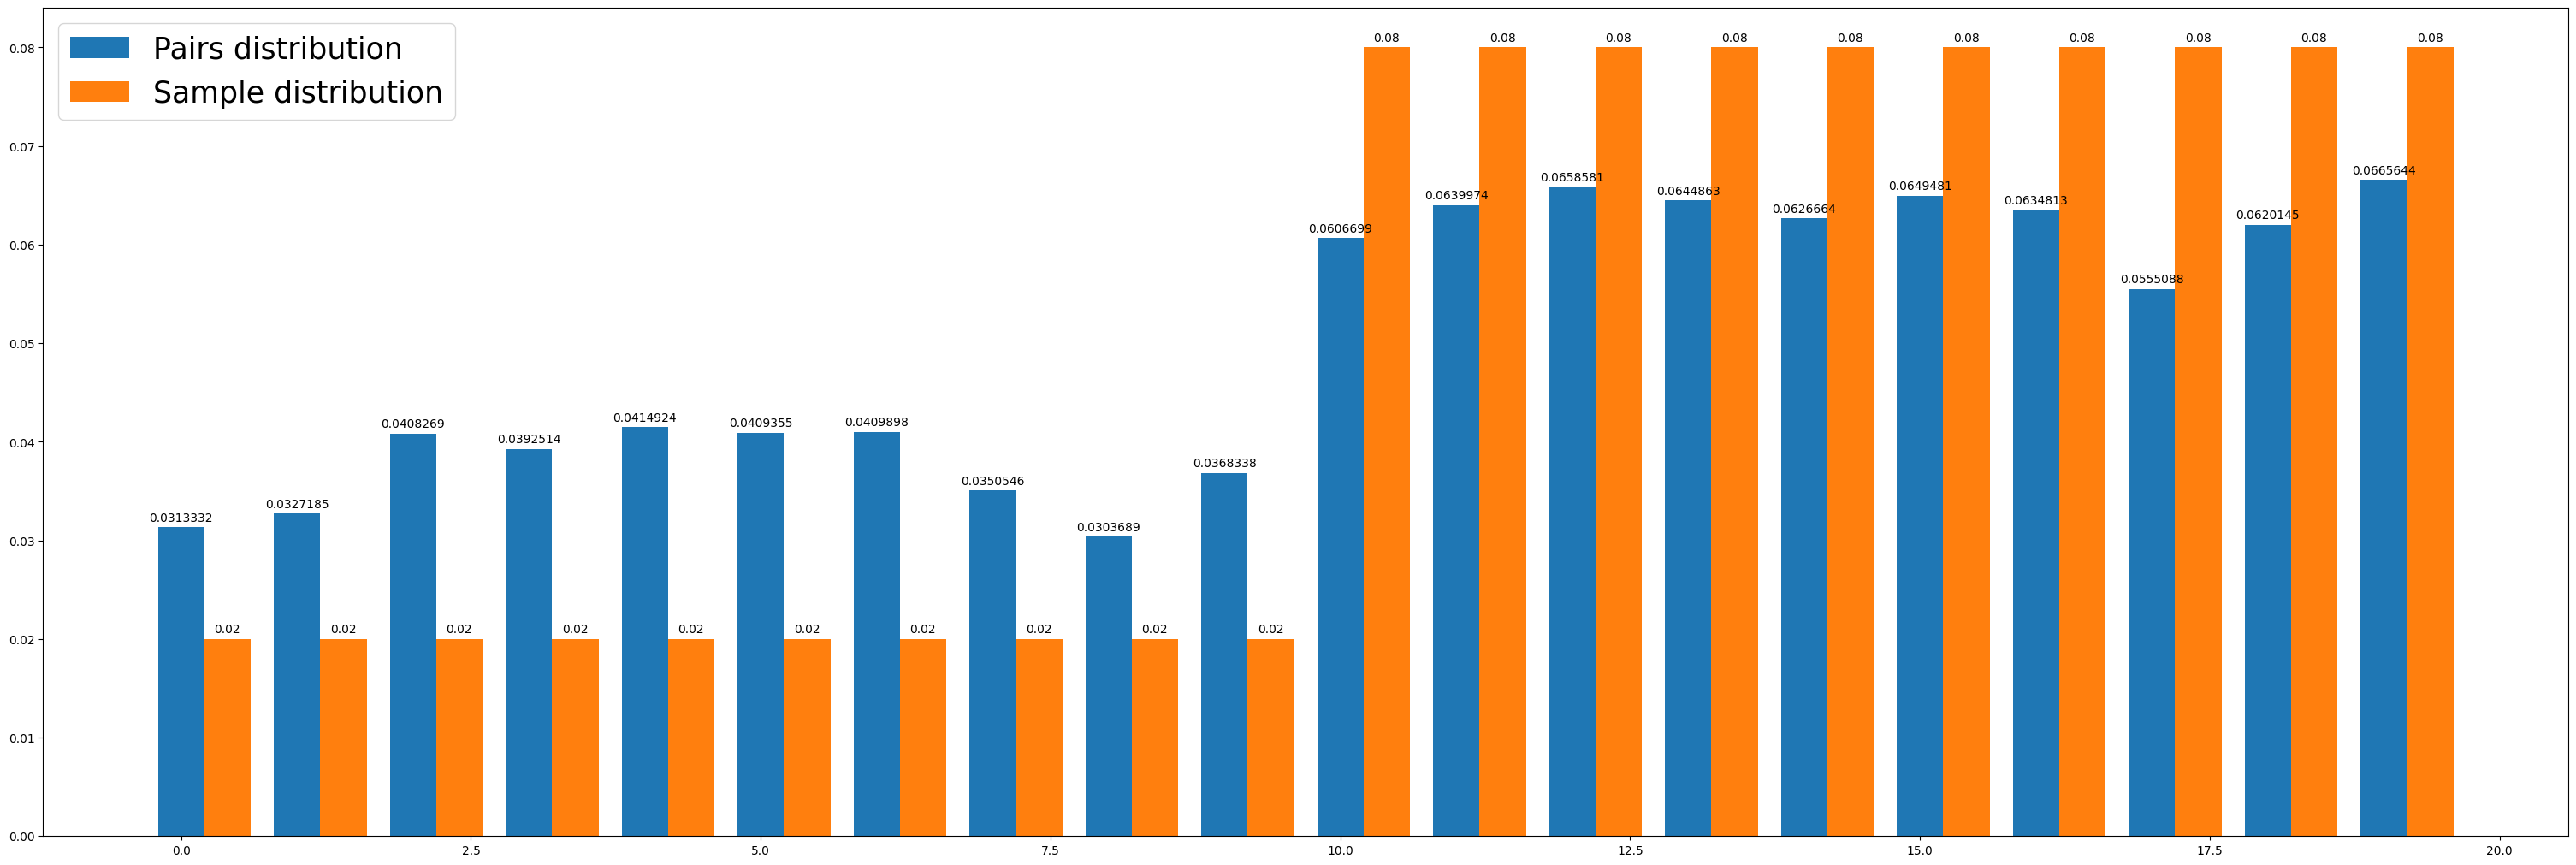

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pairs_path = "/gscratch/cse/lee0618/cifar-100/meta/pairs.csv"
unbalanced_pairs_path = "/gscratch/cse/lee0618/cifar-100/meta/unb_pairs.csv"

def get_pairs_sample_distribution(df, plot=False, num_groups=20):
    group_cnt = np.zeros(num_groups)
    for i in range(len(df)):
        group = int(df.loc[i, "aux_1"])
        group_cnt[group] += 1
    group_dist = group_cnt / len(df)
    if plot:
        fig = plt.figure(figsize=(30, 10))
        plt.bar(x=range(num_groups), height=group_dist)
    return group_dist

get_pairs_sample_distribution(pd.read_csv(pairs_path, index_col=0), plot=True)
unbalanced_pairs_dist = get_pairs_sample_distribution(pd.read_csv(unbalanced_pairs_path, index_col=0))
sample_dist = get_unbalanced_distribution()
width = 0.4
x = np.arange(20)
fig, ax = plt.subplots(layout="constrained", figsize=(30, 10))
rects = ax.bar(x=x, 
              height=unbalanced_pairs_dist, 
              width=width, 
              label="Pairs distribution")
ax.bar_label(rects, padding=3)
rects = ax.bar(x=x+width,
               height=sample_dist,
               width=width,
               label="Sample distribution")
ax.bar_label(rects, padding=3)
ax.legend(loc='upper left', prop={'size': 25})

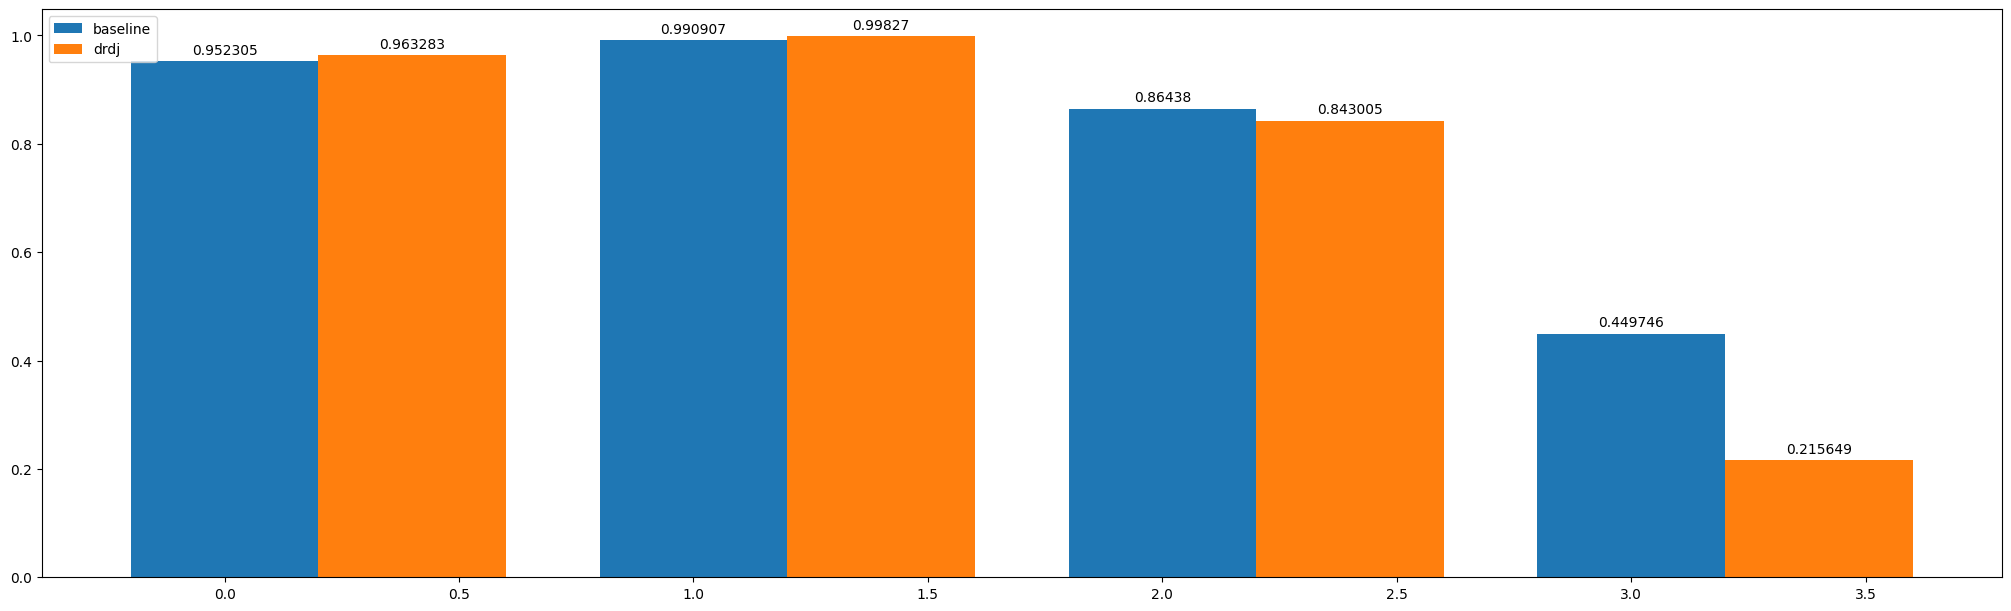

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# unb_baseline_path = "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/unb_cifar100_resnet50_baseline_group_eval.csv"
# baseline_path = "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/cifar100_resnet50_baseline_group_eval.csv"
# unb_drdj_path = "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/unb_cifar100_resnet50_drdj_vanilla_group_eval.csv"
# drdj_path = "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/cifar100_resnet50_drdj_vanilla_group_eval.csv"

baseline_path = "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/celebA_resnet50_baseline_group_eval.csv"
drdj_path = "/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/celebA_resnet50_drdj_vanilla_group_eval.csv"

accs = []
# unb_baseline = pd.read_csv(unb_baseline_path, index_col=0)
baseline = pd.read_csv(baseline_path, index_col=0)
drdj = pd.read_csv(drdj_path, index_col=0)
# unb_drdj = pd.read_csv(unb_drdj_path, index_col=0)

models = [baseline, drdj]
names = ["baseline", "drdj"]

def accuracy_bar_by_group(models, names, num_groups=20):
    fig, ax = plt.subplots(layout="constrained", figsize=(20, 6))
    x = np.arange(num_groups)
    width = 0.4
    patterns = ["", ""]
    for i, (name, model) in enumerate(zip(names, models)):
        accuracies = model["accuracy"].iloc[-num_groups:]
        rects = ax.bar(x=x + width * i, 
                    height=accuracies, 
                    width=width, 
                    label=name, 
                    hatch=[patterns[0]] * num_groups)
        ax.bar_label(rects, padding=3)
    ax.legend(loc='upper left', prop={'size': 10})

accuracy_bar_by_group([baseline, drdj], ["baseline", "drdj"], num_groups=4)
# accuracy_bar_by_group([unb_baseline, unb_drdj], ["unbalanced baseline", "unbalanced drdj"])
# accuracy_bar_by_group([baseline, unb_baseline], ["baseline", "unbalanced baseline"])
# accuracy_bar_by_group([drdj, unb_drdj], ["drdj", "unbalanced drdj"])

In [10]:
# maximum drop down
def max_accuracy_drop(df):
    return df["accuracy"].max() - df["accuracy"].min()

# average drop down
def avg_accuracy_drop(baseline_df, compared_df, indices=range(10)):
    return (baseline_df["accuracy"] - compared_df["accuracy"])[indices].mean()

def overall_accuracy(df, indices=0):
    return df["accuracy"][indices].mean()

def worst_group_accuracy(df):
    return df["accuracy"][1:].min()

print(f"average accuracy balanced baseline: {overall_accuracy(baseline)}")
print(f"average accuracy unbalanced baseline: {overall_accuracy(unb_baseline)}")
print(f"average accuracy balanced drdj: {overall_accuracy(drdj)}")
print(f"average accuracy unbalanced drdj: {overall_accuracy(unb_drdj)}")
print()
print(f"minor group accuracy balanced baseline: {overall_accuracy(baseline, indices=range(10))}")
print(f"minor group accuracy unbalanced baseline: {overall_accuracy(unb_baseline, indices=range(10))}")
print(f"minor group accuracy balanced drdj: {overall_accuracy(drdj, indices=range(10))}")
print(f"minor group accuracy unbalanced drdj: {overall_accuracy(unb_drdj, indices=range(10))}")
print()
print(f"worst group accuracy balanced baseline: {worst_group_accuracy(baseline)}")
print(f"worst group accuracy unbalanced baseline: {worst_group_accuracy(unb_baseline)}")
print(f"worst group accuracy balanced drdj: {worst_group_accuracy(drdj)}")
print(f"worst group accuracy unbalanced drdj: {worst_group_accuracy(unb_drdj)}")
print()
print(f"max accuracy drop balanced baseline: {max_accuracy_drop(baseline)}")
print(f"max accuracy drop unbalanced baseline: {max_accuracy_drop(unb_baseline)}")
print(f"max accuracy drop balanced drdj: {max_accuracy_drop(drdj)}")
print(f"max accuracy drop unbalanced drdj: {max_accuracy_drop(unb_drdj)}")
print()
print(f"average accuracy drop baseline: {avg_accuracy_drop(baseline, unb_baseline)}")
print(f"average accuracy drop drdj: {avg_accuracy_drop(baseline, unb_drdj)}")

average accuracy balanced baseline: 0.6852254746835443
average accuracy unbalanced baseline: 0.6519976265822784
average accuracy balanced drdj: 0.6793908227848101
average accuracy unbalanced drdj: 0.65361328125

minor group accuracy balanced baseline: 0.6936443846337846
minor group accuracy unbalanced baseline: 0.5895310591237667
minor group accuracy balanced drdj: 0.6867456070319451
minor group accuracy unbalanced drdj: 0.5866378281136545

worst group accuracy balanced baseline: 0.4771158807934859
worst group accuracy unbalanced baseline: 0.3928717622839952
worst group accuracy balanced drdj: 0.4693117882960882
worst group accuracy unbalanced drdj: 0.3661448003724217

max accuracy drop balanced baseline: 0.32629432758459676
max accuracy drop unbalanced baseline: 0.4474304674077792
max accuracy drop balanced drdj: 0.3713208093092991
max accuracy drop unbalanced drdj: 0.48302355833256094

average accuracy drop baseline: 0.10411332551001806
average accuracy drop drdj: 0.10700655652013032

Text(0.5, 1.0, 'Balanced Split')

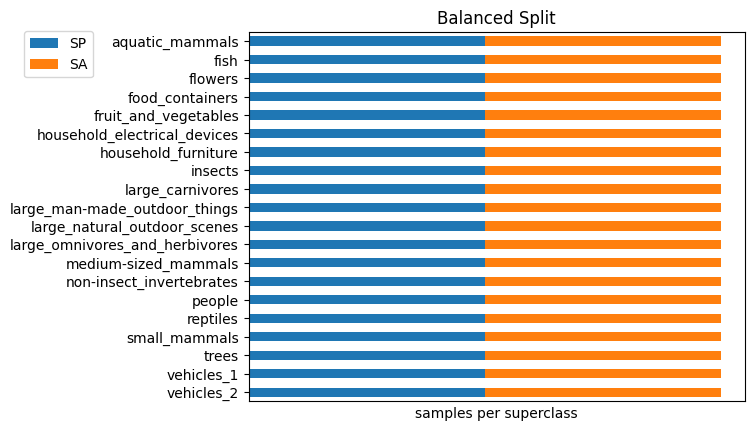

In [5]:
import pandas as pd
import json

super_classes = json.load(open(f"/gscratch/cse/lee0618/cifar-100/meta/superclass_id.json"))
super_classes = [super_classes[key] for key in super_classes]
split_1 = [0.5] * 10 + [0.5] * 10
split_2 = [0.5] * 10 + [0.5] * 10
index = super_classes[::-1]
df = pd.DataFrame({'SP': split_1[::-1],
                   'SA': split_2[::-1]}, index=index)
ax = df.plot.barh(stacked=True)
ax.set_xlabel("samples per superclass")
ax.set_xticks([])
ax.legend(bbox_to_anchor=(-0.3, 1.02))
ax.set_title("Balanced Split")

In [5]:
from wilds import get_dataset

root = "/gscratch/cse/lee0618/celebA"
dataset = get_dataset(dataset="celebA",
            download=False,
            root_dir=root)

In [3]:
import pandas as pd
import os

path = "/gscratch/cse/lee0618/celebA/celebA_v1.0/list_attr_celeba.csv"
root = "/gscratch/cse/lee0618/celebA/celebA_v1.0/img_align_celeba"
df = pd.read_csv(path)
for i in range(len(df)):
    image_id = df.iloc[i]["image_id"]
    image_path = os.path.join(root, image_id)
    if not os.path.exists(image_path):
        print(f"{image_id} doesn't exist")

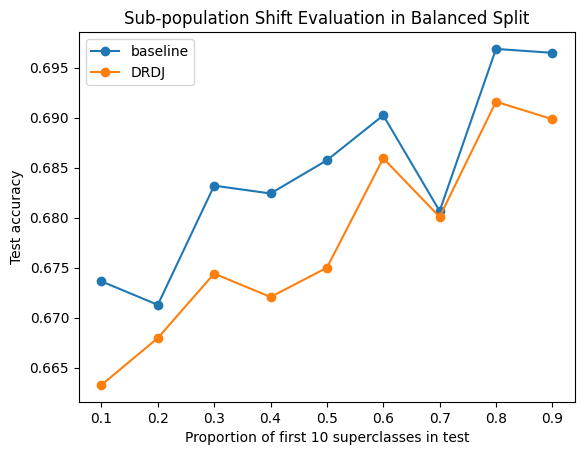

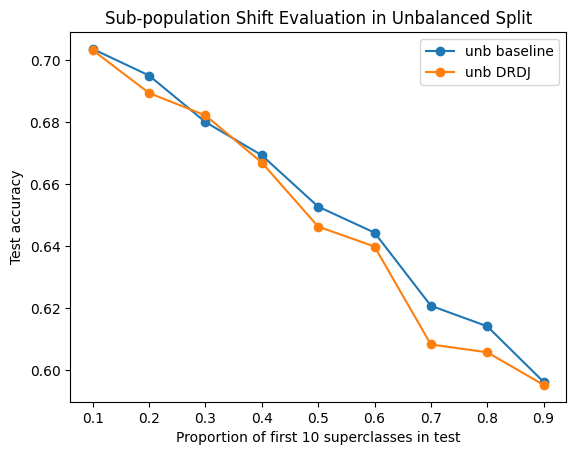

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

baseline = pd.read_csv("/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/cifar100_baseline_subpopulation_eval.csv", index_col=0)
unb_baseline = pd.read_csv("/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/unb_cifar100_baseline_subpopulation_eval.csv", index_col=0)
drdj = pd.read_csv("/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/cifar100_drdj_subpopulation_eval.csv", index_col=0)
unb_drdj = pd.read_csv("/gscratch/jamiemmt/andersonlee/image-distributionally-robust-data-join/src/misc/unb_cifar100_drdj_subpopulation_eval.csv", index_col=0)

ratios = [(0.1 * (10-i), 0.1 * i) for i in range(1, 10)]
xs = [round(r[0], 2) for r in ratios]
fig = plt.figure()
plt.plot(xs, baseline["accuracy"], label="baseline", linestyle="-", marker="o")
plt.plot(xs, drdj["accuracy"], label="DRDJ", linestyle="-", marker="o")
plt.xlabel("Proportion of first 10 superclasses in test")
plt.ylabel("Test accuracy")
plt.title("Sub-population Shift Evaluation in Balanced Split")
plt.legend()
fig = plt.figure()
plt.plot(xs, unb_baseline["accuracy"], label="unb baseline", linestyle="-", marker="o")
plt.plot(xs, unb_drdj["accuracy"], label="unb DRDJ", linestyle="-", marker="o")
plt.xlabel("Proportion of first 10 superclasses in test")
plt.ylabel("Test accuracy")
plt.title("Sub-population Shift Evaluation in Unbalanced Split")
plt.legend()